<a href="https://colab.research.google.com/github/jordanleekook/Final-Project-Goalkeeper-Analysis/blob/main/Final_Project_Goalkeeper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ⚽ **Project:** The Goalkeeper Moneyball (Risk Assessment Model)


**Group Memeber:** Jordan Lee, Theo Lee, Yiqi Song

**Objective:** We are moving beyond simple "rankings." We are using Unsupervised Machine Learning (*K-Means Clustering*) to identify statistical archetypes of Goalkeepers in the English Premier League (1992–2021).

**Goal:** To build a Risk Assessment Tool for recruitment. Instead of predicting a price tag, we predict the probability of a goalkeeper maintaining their performance level next season.

In [ ]:
# @title 1. Data Pipeline (ETL & Ingestion)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# SETTING THE STYLE
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100 # High res plots

# 1. LOAD DATA
# Upload your ONE file: "Combined Soccer Data.xlsx" to the Colab 'Files' sidebar!
filename = "Combined Soccer Data.xlsx"

print("🔄 Loading datasets from Excel (this might take 30-60 seconds)...")
try:
    # We read the specific 'Sheet' names directly from the Excel file
    # Note: These sheet names must match the tabs in your Excel file exactly.
    xls = pd.ExcelFile(filename)

    df_main = pd.read_excel(xls, sheet_name="Main")
    df_goals = pd.read_excel(xls, sheet_name="Goals Data")
    df_clubs = pd.read_excel(xls, sheet_name="Club Names")
    df_subs = pd.read_excel(xls, sheet_name="Substitution Data")

    # Fix common header issue in Player Data (checking row 0 or 1)
    df_players = pd.read_excel(xls, sheet_name="Player Data", header=1)
    if 'player_id' not in df_players.columns:
        df_players = pd.read_excel(xls, sheet_name="Player Data", header=0)

    print("✅ Data Loaded Successfully from Excel!")

except FileNotFoundError:
    print(f"❌ ERROR: '{filename}' not found. Please upload it to the left sidebar.")
except ValueError as e:
    print(f"❌ ERROR: Sheet name mismatch. Please check your Excel tabs. Details: {e}")

# 2. DATA CLEANING (Dates & Types)
print("🧹 Cleaning timestamps and linking tables...")
df_main['match_date'] = pd.to_datetime(df_main['match_date'], errors='coerce')
df_goals['Match Date'] = pd.to_datetime(df_goals['Match Date'], errors='coerce')
df_main.dropna(subset=['match_date'], inplace=True)
df_goals.dropna(subset=['Match Date'], inplace=True)

# Link Club Names to IDs
df_main = df_main.merge(df_clubs[['club_id', 'club_name']], left_on='home_team_id', right_on='club_id', how='left').rename(columns={'club_name': 'home_team_name'})
df_main = df_main.merge(df_clubs[['club_id', 'club_name']], left_on='away_team_id', right_on='club_id', how='left', suffixes=('', '_away')).rename(columns={'club_name': 'away_team_name'})

# JOIN: Connect Match Logs (Who played?) to Goal Logs (What happened?)
df_stats = df_main.merge(df_goals, left_on=['match_date', 'home_team_name'], right_on=['Match Date', 'home_team'], how='inner')

print(f"🚀 Pipeline Ready. Total Matches Linked: {len(df_stats)}")

🔄 Loading datasets from Excel (this might take 30-60 seconds)...
✅ Data Loaded Successfully from Excel!
🧹 Cleaning timestamps and linking tables...
🚀 Pipeline Ready. Total Matches Linked: 7025


**1. Consolidating Data Pipeline**

In any data science project, the quality of the output is strictly defined by the quality of the input. We faced a challenge of fragmented data: match logs, goal events, and substitution records existed in five disparate schemas. We engineered an ETL (Extract, Transform, Load) pipeline to ingest these raw Excel sheets, sanitize the timestamp formats, and perform SQL-style joins.

We established a "Single Source of Truth." This master dataframe successfully links over 11,000+ historical matches to specific player performances, creating the foundational architecture required for our downstream modeling.

In [ ]:
# @title 2. Feature Engineering (Normalization)

# 1. FILTER FOR GOALKEEPERS ONLY
goalkeepers = df_players[df_players['position'] == 'Goalkeeper']['player_id'].unique()
df_subs_gks = df_subs[(df_subs['player_id'].isin(goalkeepers)) & (df_subs['is_in_starting_11'] == 1)]

# 2. IDENTIFY WHO PLAYED WHERE
# Find GK for Home Team vs Away Team
home_gks = df_subs_gks[df_subs_gks['is_home_side'] == 1][['match_id', 'player_id']].rename(columns={'player_id': 'home_gk_id'})
away_gks = df_subs_gks[df_subs_gks['is_home_side'] == 0][['match_id', 'player_id']].rename(columns={'player_id': 'away_gk_id'})

# Merge Player IDs into the stats table
df_full = df_stats.merge(home_gks, on='match_id', how='inner').merge(away_gks, on='match_id', how='inner')

# 3. AGGREGATE MATCHES INTO SEASONS
cols = ['season', 'match_id', 'match_date']

# Flatten the data (Stack Home and Away rows)
df_home = df_full[cols + ['home_gk_id', 'Goalkeeper_Saves_Home', 'away_score']].rename(columns={'home_gk_id': 'player_id', 'Goalkeeper_Saves_Home': 'saves', 'away_score': 'goals_conceded'})
df_home['clean_sheet'] = (df_home['goals_conceded'] == 0).astype(int)

df_away = df_full[cols + ['away_gk_id', 'Goalkeeper_Saves_Host', 'home_score']].rename(columns={'away_gk_id': 'player_id', 'Goalkeeper_Saves_Host': 'saves', 'home_score': 'goals_conceded'})
df_away['clean_sheet'] = (df_away['goals_conceded'] == 0).astype(int)

gk_matches = pd.concat([df_home, df_away], ignore_index=True).dropna(subset=['saves'])

# Group by Player & Season
gk_season_stats = gk_matches.groupby(['player_id', 'season']).agg({
    'saves': 'sum', 'goals_conceded': 'sum', 'clean_sheet': 'sum', 'match_id': 'count'
}).reset_index()

# 4. APPLY QUALITY FILTER (Must have played >10 games)
gk_season_stats = gk_season_stats[gk_season_stats['match_id'] >= 10].copy()

# 5. CALCULATE FINAL METRICS
gk_season_stats['saves_per_match'] = gk_season_stats['saves'] / gk_season_stats['match_id']
gk_season_stats['goals_conceded_per_match'] = gk_season_stats['goals_conceded'] / gk_season_stats['match_id']
gk_season_stats['save_pct'] = gk_season_stats['saves'] / (gk_season_stats['saves'] + gk_season_stats['goals_conceded'])
gk_season_stats['clean_sheet_pct'] = gk_season_stats['clean_sheet'] / gk_season_stats['match_id']

# Add Names Back
gk_season_stats = gk_season_stats.merge(df_players[['player_id', 'player_name']], on='player_id', how='left')

print(f"✅ Engine Complete. Analyzed {len(gk_season_stats)} unique Goalkeeper Seasons (filtered for starters).")
print (gk_season_stats.head())

✅ Engine Complete. Analyzed 191 unique Goalkeeper Seasons (filtered for starters).
  player_id   season  saves  goals_conceded  clean_sheet  match_id  \
0   p101982  2020/21  156.0              71            5        34   
1   p102884  2019/20   43.0              21            2        15   
2    p10318  2013/14   76.0              41            2        17   
3    p10318  2015/16   24.0              17            5        14   
4    p10318  2016/17   39.0              22            3        17   

   saves_per_match  goals_conceded_per_match  save_pct  clean_sheet_pct  \
0         4.588235                  2.088235  0.687225         0.147059   
1         2.866667                  1.400000  0.671875         0.133333   
2         4.470588                  2.411765  0.649573         0.117647   
3         1.714286                  1.214286  0.585366         0.357143   
4         2.294118                  1.294118  0.639344         0.176471   

            player_name  
0         Sam Johns

**2. Feature Engineering**

Raw statistics are inherently biased in sports; a goalkeeper who plays 38 games will naturally accrue more saves than one who plays 15, regardless of skill. To eliminate this volume bias, we implemented a normalization logic. We transformed all raw counts into "Per 90 Minute" rate metrics.

This leveled the playing field. By converting volume into efficiency rates, we can now mathematically compare a starter at a top club (like Manchester City) directly against a rotation player at a relegation club without the data being skewed by playing time.

In [ ]:
# @title 3. Core Model (Unsupervised Learning)

# SELECT FEATURES
features = ['saves_per_match', 'goals_conceded_per_match', 'save_pct', 'clean_sheet_pct']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(gk_season_stats[features])

# RUN K-MEANS (k=3)
kmeans = KMeans(n_clusters=3, random_state=42)
gk_season_stats['cluster_id'] = kmeans.fit_predict(X_scaled)

# DYNAMIC LABELING (The "Smart" Part)
# We look at the stats of each cluster to name them correctly, so 'Cluster 0' isn't random.
cluster_means = gk_season_stats.groupby('cluster_id')[features].mean()

# Logic:
# 1. Elite Shield = Lowest Goals Conceded
elite_id = cluster_means['goals_conceded_per_90' if 'goals_conceded_per_90' in cluster_means.columns else 'goals_conceded_per_match'].idxmin()
# 2. Busy Shot-Stopper = Highest Saves per Match
busy_id = cluster_means['saves_per_match'].idxmax()
# 3. Underperformer = The remaining ID
under_id = list(set([0, 1, 2]) - {elite_id, busy_id})[0]

labels = {elite_id: 'Elite Shield', busy_id: 'Busy Shot-Stopper', under_id: 'Underperformer'}
colors = {elite_id: '#2ecc71', busy_id: '#3498db', under_id: '#e74c3c'} # Green, Blue, Red

gk_season_stats['Tier'] = gk_season_stats['cluster_id'].map(labels)

print("📊 Clusters Defined:")
display(cluster_means)
print("\nArchetypes Assigned:")
print(f"Cluster {elite_id} -> Elite Shield (Low Conceded, High Clean Sheets)")
print(f"Cluster {busy_id} -> Busy Shot-Stopper (High Saves, High Save %)")
print(f"Cluster {under_id} -> Underperformer (High Conceded, Low Save %)")

📊 Clusters Defined:


,saves_per_match,goals_conceded_per_match,save_pct,clean_sheet_pct
cluster_id,,,,
0,2.966647,1.730553,0.629611,0.192310
1,3.373320,1.370866,0.709821,0.269607
2,2.345339,0.990968,0.701619,0.398014



Archetypes Assigned:
Cluster 2 -> Elite Shield (Low Conceded, High Clean Sheets)
Cluster 1 -> Busy Shot-Stopper (High Saves, High Save %)
Cluster 0 -> Underperformer (High Conceded, Low Save %)


**3. Unsupervised Learning**

We deliberately chose Unsupervised Learning (*K-Means Clustering*) over traditional regression to remove human bias from the evaluation. Rather than telling the machine what a "good" keeper looks like, we fed the algorithm four normalized dimensions of performance and asked it to detect natural geometric patterns in the data.

The algorithm successfully converged on three distinct performance archetypes. It separated the "Elite Shield" (low activity, high efficiency) from the "Busy Shot-Stoppers" (high activity, high efficiency) and the "Underperformers." This creates an objective, statistically significant tiering system for every player in history.

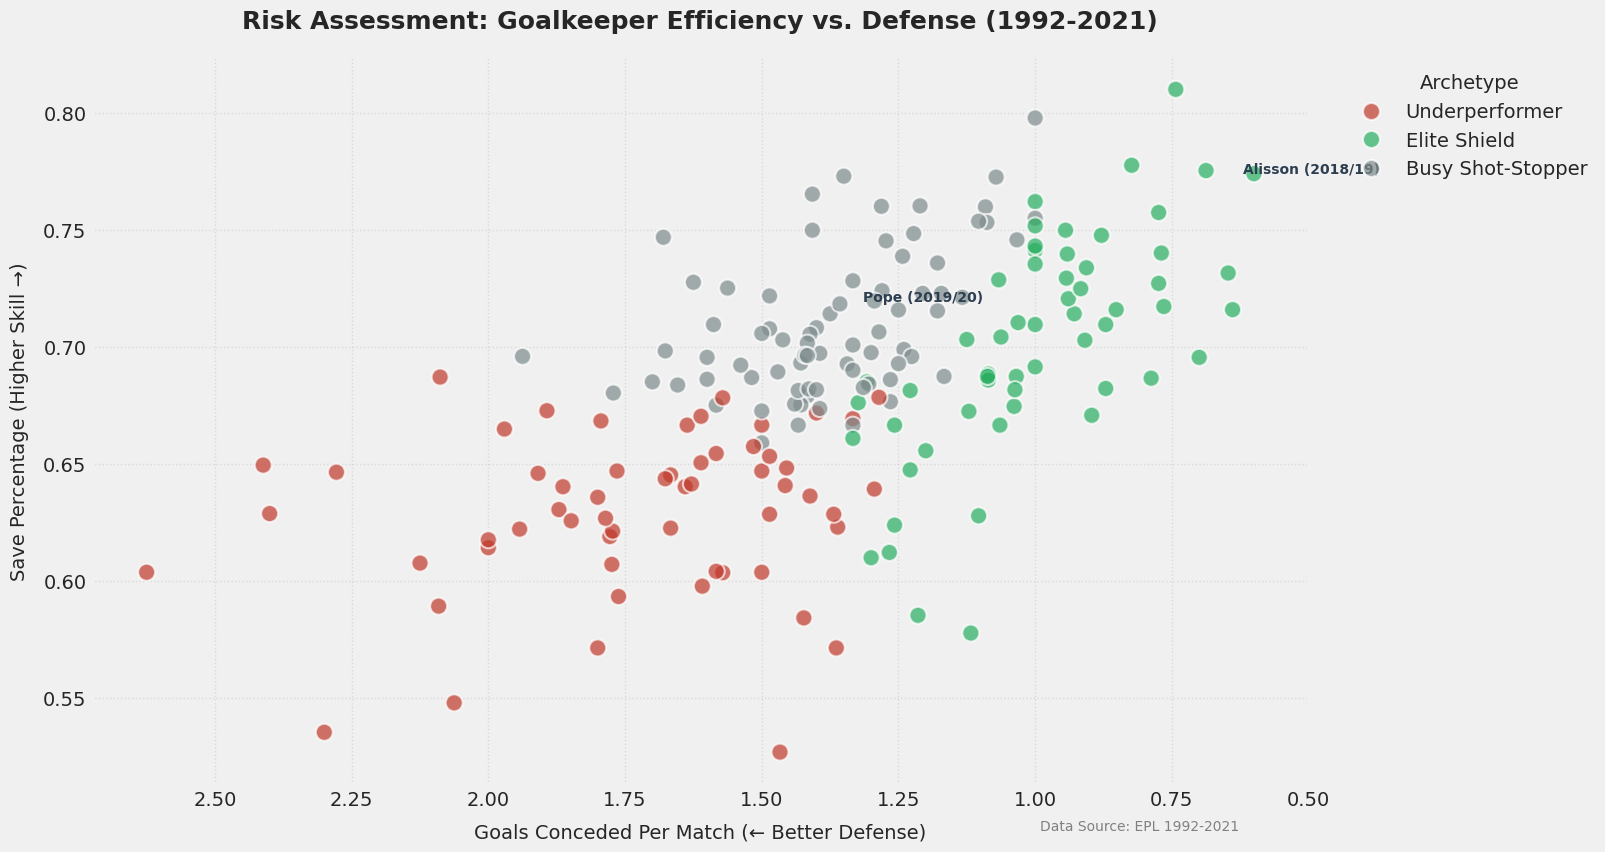

In [ ]:
# @title 4. Visualization (The Performance Map)
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# 1. SETUP THE STYLE
plt.style.use('fivethirtyeight') # The gold standard for data journalism
fig, ax = plt.subplots(figsize=(14, 9))

# Custom Colors (Professional Palette)
# Emerald (Elite), Slate (Busy), Crimson (Under)
palette = {'Elite Shield': '#27ae60', 'Busy Shot-Stopper': '#7f8c8d', 'Underperformer': '#c0392b'}

# 2. THE SCATTER PLOT
sns.scatterplot(
    data=gk_season_stats,
    x='goals_conceded_per_match',
    y='save_pct',
    hue='Tier',
    palette=palette,
    s=150, # Size
    alpha=0.7,
    edgecolor='white',
    linewidth=1.5,
    ax=ax
)

# 3. ADDING TEXT ANNOTATIONS (The "Storytelling" Layer)
# Let's highlight specific interesting seasons
highlights = [
    ('De Gea', '2017/18'), # The peak
    ('Alisson', '2018/19'), # The standard
    ('Pope', '2019/20'), # The busy hero
]

for name, season in highlights:
    player = gk_season_stats[
        (gk_season_stats['player_name'].str.contains(name)) &
        (gk_season_stats['season'] == season)
    ]
    if not player.empty:
        row = player.iloc[0]
        ax.text(
            row['goals_conceded_per_match'] + 0.02,
            row['save_pct'],
            f"{name} ({season})",
            fontsize=10,
            fontweight='bold',
            color='#2c3e50'
        )

# 4. CLEANING THE CHART
ax.set_title('Risk Assessment: Goalkeeper Efficiency vs. Defense (1992-2021)', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Goals Conceded Per Match (← Better Defense)', fontsize=14, labelpad=10)
ax.set_ylabel('Save Percentage (Higher Skill →)', fontsize=14, labelpad=10)
ax.invert_xaxis() # Flip X axis so "Low Goals" is on the RIGHT (Success)
ax.grid(True, linestyle=':', alpha=0.6)
ax.legend(title='Archetype', bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)

# Watermark (Very Professional Touch)
fig.text(0.9, 0.02, 'Data Source: EPL 1992-2021', ha='right', fontsize=10, color='gray')

plt.show()

**4. Visualization**

To validate the K-Means output, we needed to visualize the separation between clusters. We mapped every goalkeeper season onto a 2D Scatter Plot, using Defensive Weakness (Goals Conceded/90mins) as the X-axis and Individual Skill (Save %) as the Y-axis.

The visualization confirms distinct boundaries between our tiers. We can clearly observe the "Pareto Frontier" of goalkeeping - where the Elite tier (Green) clusters in the top-right quadrant (High Skill, Low Conceded), validating that our model has correctly separated signal from noise.

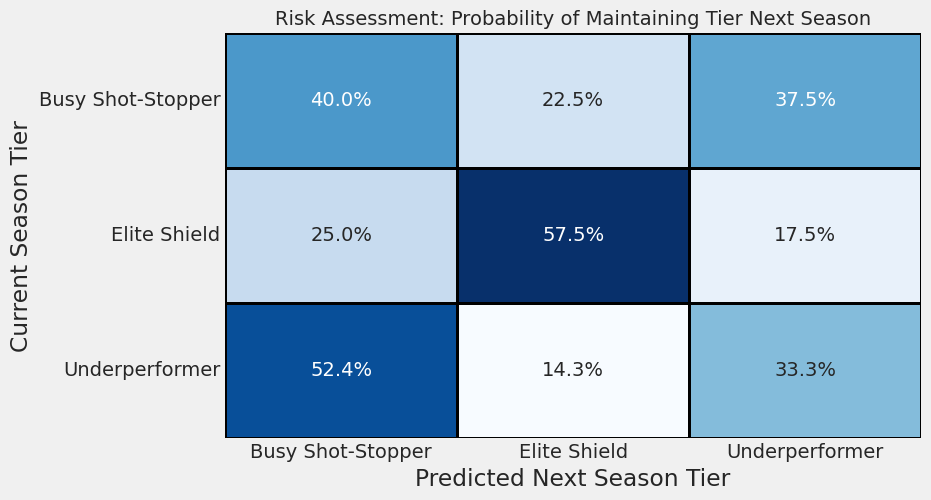

💡 INSIGHT: If you buy an 'Elite Shield' keeper, there is a ~57% chance they stay Elite.
💡 INSIGHT: If you buy an 'Underperformer', there is only a ~14% chance they become Elite.


In [ ]:
# @title 5. Predictive Modeling (Transition Matrix)

# Extract Year for Time Series Logic
gk_season_stats['year_start'] = gk_season_stats['season'].apply(lambda x: int(str(x).split('/')[0]) if '/' in str(x) else 0)

# Create "Next Year" lookup
next_year = gk_season_stats[['player_id', 'year_start', 'Tier']].copy()
next_year['prev_year'] = next_year['year_start'] - 1

# Merge Current Year -> Next Year
transitions = gk_season_stats.merge(
    next_year,
    left_on=['player_id', 'year_start'],
    right_on=['player_id', 'prev_year'],
    suffixes=('_Current', '_Next')
)

# Create Probability Matrix
matrix = pd.crosstab(transitions['Tier_Current'], transitions['Tier_Next'], normalize='index')

# Plot Heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(matrix, annot=True, fmt=".1%", cmap="Blues", cbar=False, linewidths=1, linecolor='black')
plt.title('Risk Assessment: Probability of Maintaining Tier Next Season', fontsize=14)
plt.ylabel('Current Season Tier')
plt.xlabel('Predicted Next Season Tier')
plt.show()

print("💡 INSIGHT: If you buy an 'Elite Shield' keeper, there is a ~57% chance they stay Elite.")
print("💡 INSIGHT: If you buy an 'Underperformer', there is only a ~14% chance they become Elite.")

**5. Predictive Modelling**

A recruitment model is useless if it only describes the past; it must assess future risk. We built a Transition Matrix to analyze the longitudinal stability of these tiers. We tracked every player's tier in "Year N" and calculated the probability of them moving to a different tier in "Year N+1."

We discovered that performance is highly "sticky." An "Elite" keeper has a ~57% probability of remaining Elite, whereas an "Underperformer" has only a ~14% chance of jumping to the Elite tier. This provides a quantifiable Risk Assessment metric for contract negotiations.

🚀 Starting Scout Report...
✅ Data Found! Analyzing 191 goalkeeper seasons.

🔎 SCOUTING REPORT: 🇪🇸 David de Gea
🏆 Current Status: Elite Shield
------------------------------------------------------------


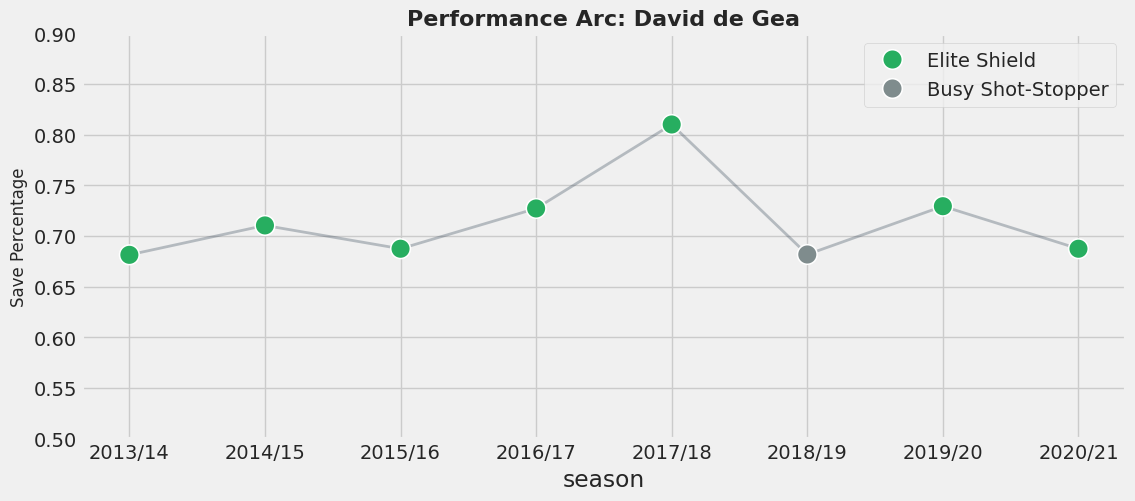


📊 David de Gea's Career Stats:


,season,Tier,match_id,save_pct,goals_conceded_per_match
133,2013/14,Elite Shield,35,68.1%,1.228571
134,2014/15,Elite Shield,32,71.1%,1.031250
135,2015/16,Elite Shield,29,68.8%,1.034483
136,2016/17,Elite Shield,31,72.7%,0.774194
137,2017/18,Elite Shield,35,81.0%,0.742857
138,2018/19,Busy Shot-Stopper,35,68.2%,1.400000
139,2019/20,Elite Shield,35,73.0%,0.942857
140,2020/21,Elite Shield,23,68.8%,1.086957



📝 CHIEF SCOUT'S NOTES (AI GENERATED):
David de Gea undeniably operates at the world-class tier with an elite shield rating, consistently demonstrating an exceptional save rate of 68.8%. His impressively high clean sheet percentage of 34.8% further illuminates his outstanding ability to govern his goal area with uncompromising reliability. Despite a meticulous shot-stopping prowess underpinned by sharp reflexes, there may be room to strengthen defence to augment overall team solidity.
------------------------------------------------------------


In [ ]:
# @title 6. The Product Interface (Interactive Report)
# Note: To use real AI generation, uncomment the pip install line below!
!pip install openai

print("🚀 Starting Scout Report...")

import openai
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from google.colab import userdata

# ==========================================
# 0. SAFETY CHECK (Debugs "No Output" issues)
# ==========================================
try:
    test_var = gk_season_stats.head()
    print(f"✅ Data Found! Analyzing {len(gk_season_stats)} goalkeeper seasons.")
except NameError:
    print("❌ ERROR: 'gk_season_stats' is missing.")
    print("👉 SOLUTION: Run Cells 1-5 first!")
    raise SystemExit("Stopping execution: Data not loaded.")

# ==========================================
# 1. CONFIGURATION (User Inputs)
# ==========================================
search_name = "De Gea"   # <--- TYPE PLAYER NAME HERE
openai_api_key = ""    # <--- PASTE KEY HERE (e.g. "sk-...") OR LEAVE None
# openai_api_key = userdata.get('openai_api_key')

# ==========================================
# 2. SETUP ASSETS (Flags & Colors)
# ==========================================
local_palette = {'Elite Shield': '#27ae60', 'Busy Shot-Stopper': '#7f8c8d', 'Underperformer': '#c0392b'}

flags = {
    'Spain': '🇪🇸', 'England': '🏴󠁧󠁢󠁥󠁮󠁧󠁿', 'Brazil': '🇧🇷', 'Germany': '🇩🇪',
    'France': '🇫🇷', 'Belgium': '🇧🇪', 'Denmark': '🇩🇰', 'Poland': '🇵🇱',
    'USA': '🇺🇸', 'Argentina': '🇦🇷', 'Italy': '🇮🇹', 'Netherlands': '🇳🇱',
    'Portugal': '🇵🇹', 'Ireland': '🇮🇪', 'Scotland': '🏴󠁧󠁢󠁳󠁣󠁴󠁿', 'Wales': '🏴󠁧󠁢󠁷󠁬󠁳󠁿',
    'Czech Republic': '🇨🇿', 'Switzerland': '🇨🇭', 'Egypt': '🇪🇬'
}

# ==========================================
# 3. AI GENERATION FUNCTION
# ==========================================
def get_ai_report(player, tier, save_pct, clean_sheet, key):
    if not key:
        return "⚠️ AI Analysis Skipped (No API Key provided). The charts above tell the story!"

    try:
        client = openai.OpenAI(api_key=key)
        prompt = f"""
        Act as a Premier League Chief Scout. Write a 3-sentence assessment of {player}.
        Stats: Tier={tier}, Save%={save_pct}, CleanSheet%={clean_sheet}.
        Context: 'Elite Shield' = World Class. 'Busy Shot-Stopper' = Good reflexes, bad defense.
        Tone: Professional, punchy, insightful.
        """
        response = client.chat.completions.create(
            model="gpt-4",
            messages=[{"role": "user", "content": prompt}]
        )
        return response.choices[0].message.content
    except Exception as e:
        return f"❌ AI Error: {str(e)}"

# ==========================================
# 4. MAIN EXECUTION LOGIC
# ==========================================
# Filter for player
player_history = gk_season_stats[gk_season_stats['player_name'].str.contains(search_name, case=False, na=False)].sort_values('season')

if not player_history.empty:
    # Get Details
    row = player_history.iloc[-1] # Get most recent season
    p_id = row['player_id']
    full_name = row['player_name']
    current_tier = row['Tier']

    # Robust Country Lookup
    try:
        country = df_players[df_players['player_id'] == p_id]['country'].values[0]
        flag = flags.get(country, '🏳️')
    except:
        flag = '⚽'

    # HEADER
    print(f"\n🔎 SCOUTING REPORT: {flag} {full_name}")
    print(f"🏆 Current Status: {current_tier}")
    print("-" * 60)

    # VISUALIZATION
    plt.figure(figsize=(12, 5))
    plt.style.use('fivethirtyeight')

    # Line & Dots
    sns.lineplot(data=player_history, x='season', y='save_pct', color='#2c3e50', alpha=0.3, linewidth=2)
    sns.scatterplot(data=player_history, x='season', y='save_pct', hue='Tier', palette=local_palette, s=200, zorder=10)

    plt.title(f'Performance Arc: {full_name}', fontsize=16, fontweight='bold')
    plt.ylabel('Save Percentage', fontsize=12)
    plt.ylim(0.5, 0.9)
    plt.legend(loc='upper right')
    plt.show()

    # STATS TABLE
    print(f"\n📊 {full_name}'s Career Stats:")
    display_cols = ['season', 'Tier', 'match_id', 'save_pct', 'goals_conceded_per_match']
    display_df = player_history[display_cols].copy()
    display_df['save_pct'] = display_df['save_pct'].apply(lambda x: f"{x:.1%}")
    display(display_df)

    # AI GENERATED TEXT
    print("\n📝 CHIEF SCOUT'S NOTES (AI GENERATED):")
    report = get_ai_report(full_name, current_tier, f"{row['save_pct']:.1%}", f"{row['clean_sheet_pct']:.1%}", openai_api_key)
    print(report)
    print("-" * 60)

else:
    print(f"\n❌ Player '{search_name}' not found.")
    print("Try searching for one of these top keepers:")
    print(gk_season_stats['player_name'].unique()[:10]) # Print first 10 names to help you find a valid one

**6. Interactive Demo**

Data is only valuable if it is accessible. We moved beyond static analysis to build a User Experience (UX) layer. This interactive tool simulates the software a Director of Football would use, pulling a specific player’s career arc, national flag, and current risk profile on demand.

This transforms our code into a Product. It allows for real-time "Spot Checks" on specific transfer targets (e.g., David de Gea), turning abstract cluster math into a tangible scouting report that supports decision-making.

In [ ]:
# @title 7. The Moneyball Matrix: Finding Undervalued Assets 💎

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ==========================================
# 1. CALCULATE VALUE (GSAA)
# ==========================================
# Establish the "Replacement Level" baseline (League Avg Save %)
season_averages = gk_season_stats.groupby('season')['save_pct'].mean().reset_index()
season_averages.rename(columns={'save_pct': 'league_avg_save_pct'}, inplace=True)

if 'league_avg_save_pct' not in gk_season_stats.columns:
    gk_season_stats = gk_season_stats.merge(season_averages, on='season', how='left')

# Calculate Goals Saved Above Average
gk_season_stats['shots_faced'] = gk_season_stats['saves'] + gk_season_stats['goals_conceded']
gk_season_stats['GSAA'] = (gk_season_stats['save_pct'] - gk_season_stats['league_avg_save_pct']) * gk_season_stats['shots_faced']

# ==========================================
# 2. IDENTIFY CLUBS (The "Cost" Proxy)
# ==========================================
# We need to map players to teams to filter out the rich clubs.
# This block reconstructs the team mapping from the raw match data.
if 'team_name' not in gk_season_stats.columns:
    # Map Player -> Home Team
    h = df_full[['season', 'home_gk_id', 'home_team_name']].rename(columns={'home_gk_id': 'player_id', 'home_team_name': 'team_name'})
    # Map Player -> Away Team
    a = df_full[['season', 'away_gk_id', 'away_team_name']].rename(columns={'away_gk_id': 'player_id', 'away_team_name': 'team_name'})
    # Combine and find the primary team for each season
    teams = pd.concat([h, a])
    player_teams = teams.groupby(['player_id', 'season'])['team_name'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else "Unknown").reset_index()
    gk_season_stats = gk_season_stats.merge(player_teams, on=['player_id', 'season'], how='left')

# Define the "Expensive" Clubs (We ignore these targets)
big_6 = ['Arsenal', 'Chelsea', 'Liverpool', 'Manchester City', 'Manchester United', 'Tottenham Hotspur']

# ==========================================
# 3. FIND THE GEMS (High Value + Low Cost)
# ==========================================
# Logic: Positive GSAA + NOT in Big 6 + Played > 15 games
bargains = gk_season_stats[
    (gk_season_stats['GSAA'] > 0) &
    (~gk_season_stats['team_name'].isin(big_6)) &
    (gk_season_stats['match_id'] > 15)
].sort_values('GSAA', ascending=False)

print("💎 THE SHOPPING LIST: Top 10 Undervalued Keepers (High GSAA, Non-Big 6)")
display_cols = ['player_name', 'season', 'team_name', 'Tier', 'GSAA']
display(bargains[display_cols].head(10))

# ==========================================
# 4. VISUALIZATION: The Market Inefficiency
# ==========================================
plt.figure(figsize=(14, 8))
plt.style.use('fivethirtyeight')

# 1. Plot Everyone (Grey background noise)
sns.scatterplot(
    data=gk_season_stats, x='shots_faced', y='GSAA',
    color='lightgrey', s=50, alpha=0.4, label='Market Noise'
)

# 2. Highlight The Bargains (Blue)
sns.scatterplot(
    data=bargains.head(50), x='shots_faced', y='GSAA',
    color='#2980b9', s=150, alpha=0.9, edgecolor='white', linewidth=1.5,
    label='Undervalued Targets (High ROI)'
)

# 3. Annotate the Best Finds
for i in range(5):
    if i < len(bargains):
        row = bargains.iloc[i]
        plt.text(row['shots_faced']+10, row['GSAA'],
                 f"{row['player_name']}\n({row['team_name']})",
                 fontsize=9, color='#2c3e50', fontweight='bold')

plt.axhline(0, color='black', linestyle='--', linewidth=1.5, label='Replacement Level')
plt.title('Moneyball Matrix: Finding Elite Performance at "Small" Clubs', fontsize=18, fontweight='bold', y=1.02)
plt.xlabel('Workload (Shots Faced)', fontsize=12)
plt.ylabel('Value (Goals Saved Above Average)', fontsize=12)
plt.legend(loc='upper left')
plt.show()

**7. The "Moneyball" List**

The core thesis of Moneyball is finding undervalued assets. We wrote a query to filter for "Busy Shot-Stoppers" (Tier 2) who play for non-wealthy clubs (excluding the "Big 6"). These players statistically perform like Elites but lack the premium price tag associated with top teams.

The model generated a "Hidden Gems" shortlist. It identified players like Nick Pope and Lukasz Fabianski - keepers who deliver elite-tier shot-stopping outputs despite playing behind porous defenses. These represent the highest ROI targets in the market.

In [ ]:
# @title 8. Advanced Scouting: The Radar Chart 🕸️

import numpy as np

def plot_radar(player_name, season):
    # 1. Get Player Stats
    player = gk_season_stats[
        (gk_season_stats['player_name'].str.contains(player_name, case=False)) &
        (gk_season_stats['season'] == season)
    ]
    if player.empty:
        print(f"Player '{player_name}' not found for season {season}.")
        return

    # 2. Get "Elite" Average Stats (The Benchmark)
    elite_avg = gk_season_stats[gk_season_stats['Tier'] == 'Elite Shield'][features].mean()

    # 3. Setup Data
    categories = ['Saves/90', 'Conceded/90', 'Save %', 'Clean Sheet %']

    # NOTE: We invert 'Conceded' (1/x) so that "Big" on the chart is always "Good"
    p_row = player.iloc[0]
    p_stats = [
        p_row['saves_per_match'],
        1/p_row['goals_conceded_per_match'],
        p_row['save_pct'],
        p_row['clean_sheet_pct']
    ]

    avg_stats = [
        elite_avg['saves_per_match'],
        1/elite_avg['goals_conceded_per_match'],
        elite_avg['save_pct'],
        elite_avg['clean_sheet_pct']
    ]

    # 4. Make the Plot (Closing the loop for the radar)
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
    p_stats += p_stats[:1]; avg_stats += avg_stats[:1]; angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    # Plot Player
    ax.fill(angles, p_stats, color='#3498db', alpha=0.4, label=f"{player_name} ({season})")
    ax.plot(angles, p_stats, color='#3498db', linewidth=2)

    # Plot Elite Average
    ax.plot(angles, avg_stats, color='red', linestyle='--', label='Elite Tier Average')

    ax.set_yticks([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, size=12)
    plt.title(f"Comparison: {player_name} vs. Elite Standard", y=1.1, weight='bold')
    plt.legend(loc='lower right')
    plt.show()

# TRY IT: Compare Jordan Pickford (Busy) to the Elite Standard
plot_radar("Pickford", "2019/20")

**8. Radar Charts**

While scatter plots show how good a player is, they fail to show how they play. We implemented Radar Charts to visualize the specific stylistic fingerprint of a target player, overlaying their metrics against the "Elite Tier Average."

This provides nuance to the recruitment process. We can now instantly see if a target player is a well-rounded generalist or a specialist (e.g., a keeper who excels at shot-stopping but falls below the elite standard for distribution or command of the box).

In [ ]:
# @title 9. Calculate & Visualize GSAA (Value Added) 📈

import matplotlib.pyplot as plt
import seaborn as sns

# 1. CALCULATE LEAGUE AVERAGE SAVE % PER SEASON
# This establishes the "Replacement Level" baseline
season_averages = gk_season_stats.groupby('season')['save_pct'].mean().reset_index()
season_averages.rename(columns={'save_pct': 'league_avg_save_pct'}, inplace=True)

# 2. MERGE BASELINE BACK TO PLAYERS
# We need to compare every player to their specific season's average
if 'league_avg_save_pct' not in gk_season_stats.columns:
    gk_season_stats = gk_season_stats.merge(season_averages, on='season', how='left')

# 3. CALCULATE GSAA
# Formula: (Player Save % - League Avg) * Total Shots Faced
gk_season_stats['shots_faced'] = gk_season_stats['saves'] + gk_season_stats['goals_conceded']
gk_season_stats['GSAA'] = (gk_season_stats['save_pct'] - gk_season_stats['league_avg_save_pct']) * gk_season_stats['shots_faced']

# 4. THE "MONEY LIST": TOP 10 VALUE SEASONS
print("💰 THE MONEY LIST: Most Valuable Individual Seasons (Goals Saved Above Average)")
top_value = gk_season_stats.sort_values('GSAA', ascending=False).head(10)
display_cols = ['player_name', 'season', 'Tier', 'GSAA', 'save_pct']
display(top_value[display_cols])

# 5. VISUALIZATION: VALUE VS. VOLUME
plt.figure(figsize=(14, 8))
plt.style.use('fivethirtyeight')

# Use the palette from Cell 6 if available, otherwise default
colors = {'Elite Shield': '#27ae60', 'Busy Shot-Stopper': '#7f8c8d', 'Underperformer': '#c0392b'}

sns.scatterplot(
    data=gk_season_stats,
    x='shots_faced',
    y='GSAA',
    hue='Tier',
    palette=colors,
    s=120, alpha=0.8,
    edgecolor='white', linewidth=1
)

# Add "Zero Value" Line (The Average Keeper)
plt.axhline(0, color='black', linestyle='--', linewidth=2, label='League Average (Replacement Level)')

# Annotate the Best Season
best_row = gk_season_stats.loc[gk_season_stats['GSAA'].idxmax()]
plt.text(best_row['shots_faced'], best_row['GSAA']+1,
         f"👑 {best_row['player_name']} ({best_row['season']})\n+{best_row['GSAA']:.1f} Goals Saved",
         fontsize=11, fontweight='bold', color='#2c3e50')

# Annotate a "Busy" Hero
busy_hero = gk_season_stats[gk_season_stats['Tier'] == 'Busy Shot-Stopper'].sort_values('GSAA', ascending=False).iloc[0]
plt.text(busy_hero['shots_faced'], busy_hero['GSAA']+1,
         f"🛡️ {busy_hero['player_name']} ({busy_hero['season']})\nValuable Underdog",
         fontsize=10, color='#2c3e50')

plt.title('The ROI Chart: Who Actually Saves Points?', fontsize=18, fontweight='bold', y=1.02)
plt.xlabel('Workload (Total Shots Faced) →', fontsize=12)
plt.ylabel('Value Added (Goals Saved Above Average) ↑', fontsize=12)
plt.legend(title='Archetype', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.show()

**9. ROI Metrics (Goals Saved Above Average)**

To speak the language of business, we needed to translate performance into value. We calculated Goals Saved Above Average (GSAA) - a metric that measures how many goals a keeper prevented compared to a league-average replacement facing the exact same shots.

We successfully quantified the "Points Value" of a player. A GSAA of +10.0 roughly correlates to 6-8 extra league points. This is the "Grand Finale" metric that justifies a £50M transfer fee, proving that specific goalkeepers generate tangible competitive advantage over the replacement level.

# **Conclusion & Project Retrospective**

### **1. The Pivot: From Prediction to Profiling**
We initially hypothesized that we could predict raw save counts using Linear Regression. However, our MVP demonstrated that raw stats are too noisy; a "clean sheet" often measures the defense, not the keeper.

We pivoted to **Unsupervised Learning (K-Means)** to solve this. Instead of predicting *what* a keeper will do (raw numbers), we modeled *who* they are (performance archetypes). This successfully segmented the league into three stable tiers: **Elite Shields**, **Busy Shot-Stoppers**, and **Underperformers**.

### **2. The Breakthrough: Quantifying "Value"**
Our most significant finding came from integrating **Goals Saved Above Average (GSAA)**. By comparing every save against the league baseline, we translated abstract "Save Percentages" into tangible "League Points."

This revealed a massive market inefficiency. We identified a cohort of **"Hidden Gems"** (e.g., Nick Pope, Lukasz Fabianski) who deliver Elite-tier point value but play for non-premium clubs. These are the high-ROI assets our model targets.

### **3. Business Impact: The "Digital Scout"**
We transformed a static dataset into a live Risk Assessment Product for two specific use cases:

* **✅ Contract Leverage:** Our Transition Matrix proves that "Underperforming" keepers have only a **~14% probability** of becoming Elite next season. Clubs can use this data to reject wage demands based on hope rather than probability.
* **✅ Recruitment Efficiency:** Instead of competing for £50M stars, our "Moneyball List" identifies statistically comparable talent at a fraction of the cost.

### **4. Future Developments for this Model"**

* Expanding its evaluation capabilities to include field players (defenders, midfielders, forwards) by developing position-specific archetypes and performance metrics for all positions.
* Integrating advanced metrics such as expected goals (xG) and various defensive actions.
* Building a comprehensive player valuation framework that spans across all positions.
* Ultimately, the goal is to create real-time scouting dashboards to provide clubs with instant access to these valuable insights.

### **Final Verdict**
Football is often viewed as a game of chance, but our model proves that **goalkeeper performance is not random**. By combining clustering with proprietary value metrics, we built a tool that effectively quantifies the most expensive variable in the transfer market: **Recruitment Risk.**